#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
# !pip install shap

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
# import time
# import shap

In [5]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 15):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(3,6))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [6]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [13]:
data = pd.read_csv("data01_train.csv")
new_data = pd.read_csv("data01_test.csv")

In [14]:
data = data.drop('subject', axis=1)
new_data = new_data.drop('subject', axis=1)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [15]:
label_change = {'STANDING' : 0,
                'SITTING' : 0,
                'LAYING' : 0,
                'WALKING' : 1,
                'WALKING_UPSTAIRS' : 1,
                'WALKING_DOWNSTAIRS' : 1
               }

data['Activity_dynamic'] = data['Activity'].map(label_change) # 정적 0, 동적 1

In [16]:
target_y1 = 'Activity'
target_y2 = 'Activity_dynamic'

x = data.drop([target_y1,target_y2], axis=1)
y1 = data.loc[:,target_y1]
y2 = data.loc[:,target_y2]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y2,
                                                  test_size=0.3,
                                                  random_state=1)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 : RandomForestClassifier

In [ ]:
model_rf = RandomForestClassifier(max_depth=5,
                               random_state = 1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [ ]:
y_pred_rf = model_rf.predict(x_val)

In [ ]:
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

[[952   2]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [ ]:
result = {}
result['Random_Forest'] = model_rf.score(x_val, y_val)

,feature_name,feature_importance
0,fBodyAccJerk-mad()-X,0.069960
1,tBodyAccJerk-energy()-X,0.050077
2,tBodyAccJerk-mad()-X,0.049970
3,"fBodyAccJerk-bandsEnergy()-1,24",0.049961
4,"fBodyAccJerk-bandsEnergy()-1,16",0.040332
5,tBodyAccJerkMag-sma(),0.040072
6,fBodyAccJerk-std()-X,0.039980
7,tBodyAccJerk-std()-X,0.039961
8,tBodyAccJerk-entropy()-Y,0.039863
9,fBodyAccJerk-energy()-X,0.030059


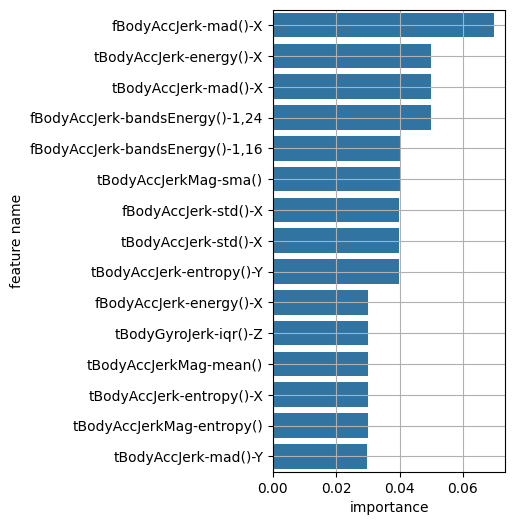

In [ ]:
# Feature importance 그리기
importance = model_rf.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

#### 2) 알고리즘2 : DNN

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
# 모델설계
nfeatures = x_train.shape[1] # num of columns
nfeatures

561

In [ ]:
# 메모리 정리
clear_session()

# Sequential
model_dnn = Sequential([Dense(128, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(1 , activation = 'sigmoid')])

# 모델요약
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               71936     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 82817 (323.50 KB)
Trainable params: 82817 (323.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
lr = 0.01
epochs = 10

model_dnn.compile(optimizer=Adam(learning_rate=lr), loss= 'binary_crossentropy', metrics=['accuracy'])
validation_data=(x_val, y_val)
hist = model_dnn.fit(x_train, y_train, epochs = epochs, validation_split=0.2).history
# hist = model_dnn.fit(x_train, y_train, epochs = epochs, validation_data=(x_val, y_val)).history

Epoch 1/10
103/103 [==============================] - 4s 15ms/step - loss: 0.0538 - accuracy: 0.9724 - val_loss: 5.9163e-06 - val_accuracy: 1.0000
Epoch 2/10
103/103 [==============================] - 1s 9ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 2.8777e-04 - val_accuracy: 1.0000
Epoch 3/10
103/103 [==============================] - 1s 7ms/step - loss: 0.0069 - accuracy: 0.9973 - val_loss: 6.1954e-05 - val_accuracy: 1.0000
Epoch 4/10
103/103 [==============================] - 1s 7ms/step - loss: 3.9239e-05 - accuracy: 1.0000 - val_loss: 7.6427e-06 - val_accuracy: 1.0000
Epoch 5/10
103/103 [==============================] - 0s 4ms/step - loss: 9.4263e-06 - accuracy: 1.0000 - val_loss: 3.3407e-06 - val_accuracy: 1.0000
Epoch 6/10
103/103 [==============================] - 0s 4ms/step - loss: 4.9953e-06 - accuracy: 1.0000 - val_loss: 1.7640e-06 - val_accuracy: 1.0000
Epoch 7/10
103/103 [==============================] - 0s 4ms/step - loss: 3.1355e-06 - accuracy: 1.0000 - val_l

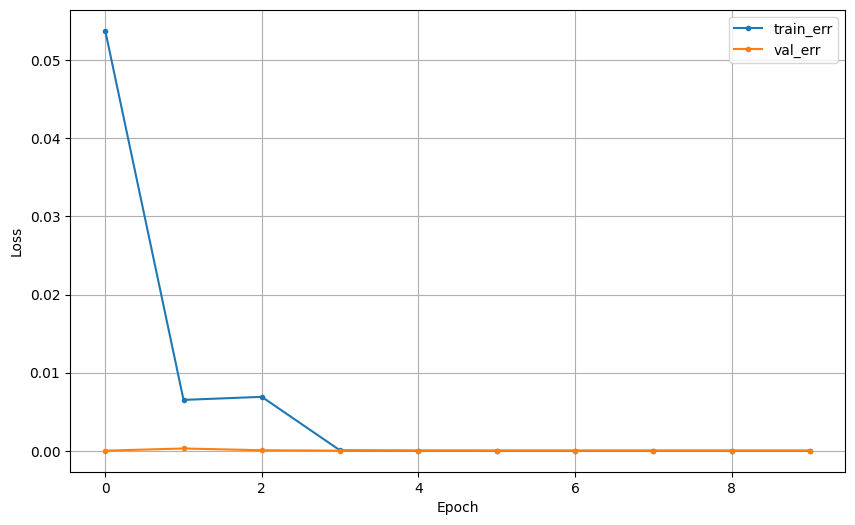

In [ ]:
dl_history_plot(hist)

In [ ]:
y_pred = model_dnn.predict(x_val)
y_pred_1 = np.where(y_pred >= 0.5 , 1 , 0)

print(confusion_matrix(y_val, y_pred_1))
print(classification_report(y_val, y_pred_1))

56/56 [==============================] - 0s 2ms/step
[[954   0]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [ ]:
result['DNN'] = model_dnn.evaluate(x_val, y_val)
result

56/56 [==============================] - 0s 2ms/step - loss: 4.2232e-05 - accuracy: 1.0000


{'Random_Forest': 0.9988668555240793, 'DNN': [4.2232346459059045e-05, 1.0]}

In [ ]:
model_dnn.save('model_dnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 1.0


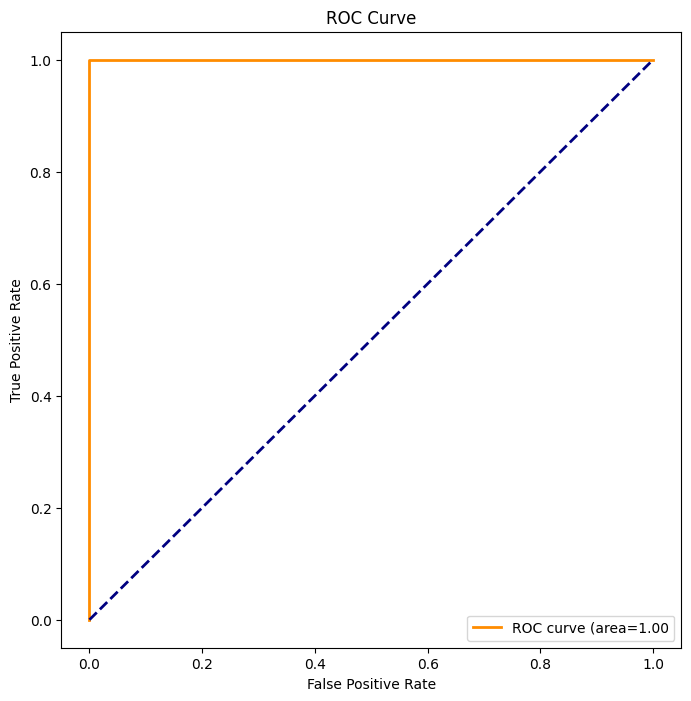

In [ ]:
fpr, tpr, th = roc_curve(y_val, y_pred)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color = 'darkorange', lw=2, label=f'ROC curve (area={roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
explainer = shap.DeepExplainer(model_dnn, x_train)

start_time = time.time()
shap_values = explainer.shap_values(x_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("SHAP 값을 계산하는데 걸린 시간: ", elapsed_time, "초")

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


SHAP 값을 계산하는데 걸린 시간:  265.93646788597107 초


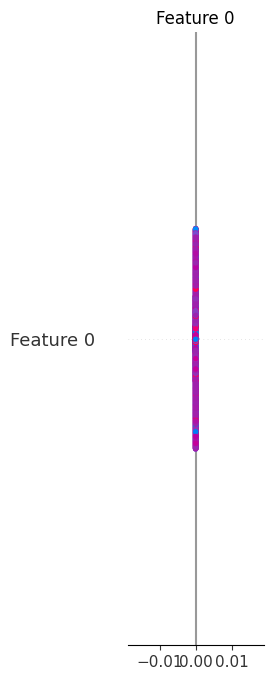

In [ ]:
shap.summary_plot(shap_values, x_train)

In [ ]:
print('=' * 80)
print('# 단계 1 : 정적/동적 행동 분류 모델')
print(result)
print('=' * 80)

# 단계 1 : 정적/동적 행동 분류 모델
{'Random_Forest': 0.9988668555240793, 'DNN': [0.004970740061253309, 0.9994333982467651]}


### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
is_static_col = ['LAYING', 'SITTING', 'STANDING']
data_is_static = data.loc[data['Activity'].isin(is_static_col)]

In [ ]:
label_change = {'LAYING' : 0,
                'SITTING' : 1,
                'STANDING' : 2}
data_is_static['Activity'] = data_is_static['Activity'].map(label_change)

<ipython-input-34-279db7e472d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_static['Activity'] = data_is_static['Activity'].map(label_change)


In [ ]:
target_y1 = 'Activity'
target_y2 = 'Activity_dynamic'

x = data_is_static.drop([target_y1,target_y2], axis=1)
y1 = data_is_static.loc[:,target_y1]
y2 = data_is_static.loc[:,target_y2]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y1,
                                                  test_size=0.3,
                                                  random_state=1)

#### 1) 알고리즘1: RandomForestClassifier

In [ ]:
model_rf = RandomForestClassifier(max_depth=5,
                               random_state = 1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [ ]:
y_pred_rf = model_rf.predict(x_val)

In [ ]:
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

[[320   0   0]
 [  0 287  30]
 [  0  23 311]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       0.93      0.91      0.92       317
           2       0.91      0.93      0.92       334

    accuracy                           0.95       971
   macro avg       0.95      0.95      0.95       971
weighted avg       0.95      0.95      0.95       971



In [ ]:
result_2 = {}
result_2['Random_Forest'] = model_rf.score(x_val, y_val)

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.078929
1,tGravityAcc-mean()-X,0.071353
2,tGravityAcc-energy()-X,0.065279
3,tGravityAcc-min()-Y,0.062235
4,tGravityAcc-max()-X,0.058173
5,tGravityAcc-max()-Y,0.050880
6,tGravityAcc-min()-X,0.047410
7,"angle(Y,gravityMean)",0.046854
8,tGravityAcc-mean()-Y,0.039715
9,tGravityAcc-min()-Z,0.033983


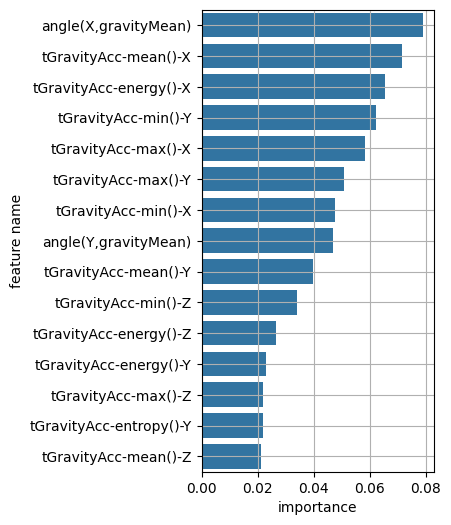

In [ ]:
# Feature importance 그리기
importance = model_rf.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

#### 2) 알고리즘2: DNN

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
# 모델설계
nfeatures = x_train.shape[1] # num of columns
nfeatures

561

In [ ]:
# 메모리 정리
clear_session()

# Sequential
model_dnn_static = Sequential([Dense(128, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(3 , activation = 'softmax')])


#아래 모델이 미세하게 정확도가 더 높았음.
# model_dnn_static = Sequential()
# model_dnn_static.add(Dense(256, input_dim=n_input, activation='elu'))
# model_dnn_static.add(Dense(128, activation='elu'))
# model_dnn_static.add(Dense(64, activation='elu'))
# model_dnn_static.add(Dense(3, activation='softmax'))
# model_dnn_static.compile(optimizer=Adam(learning_rate= 0.0001),
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

# 모델요약
model_dnn_static.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               71936     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 82851 (323.64 KB)
Trainable params: 82851 (323.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
lr = 0.01
epochs = 60

model_dnn_static.compile(optimizer=Adam(learning_rate=lr), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
validation_data=(x_val, y_val)
hist = model_dnn_static.fit(x_train, y_train, epochs = epochs, validation_split=0.2).history

Epoch 1/60
57/57 [==============================] - 2s 12ms/step - loss: 0.6346 - accuracy: 0.6735 - val_loss: 0.3654 - val_accuracy: 0.8366
Epoch 2/60
57/57 [==============================] - 0s 8ms/step - loss: 0.3224 - accuracy: 0.8575 - val_loss: 0.2453 - val_accuracy: 0.8962
Epoch 3/60
57/57 [==============================] - 0s 5ms/step - loss: 0.2053 - accuracy: 0.9204 - val_loss: 0.2628 - val_accuracy: 0.9073
Epoch 4/60
57/57 [==============================] - 0s 4ms/step - loss: 0.1505 - accuracy: 0.9420 - val_loss: 0.1233 - val_accuracy: 0.9558
Epoch 5/60
57/57 [==============================] - 0s 8ms/step - loss: 0.1294 - accuracy: 0.9459 - val_loss: 0.1052 - val_accuracy: 0.9603
Epoch 6/60
57/57 [==============================] - 0s 8ms/step - loss: 0.1948 - accuracy: 0.9260 - val_loss: 0.3553 - val_accuracy: 0.8322
Epoch 7/60
57/57 [==============================] - 0s 8ms/step - loss: 0.1220 - accuracy: 0.9508 - val_loss: 0.0957 - val_accuracy: 0.9603
Epoch 8/60
57/57 [=

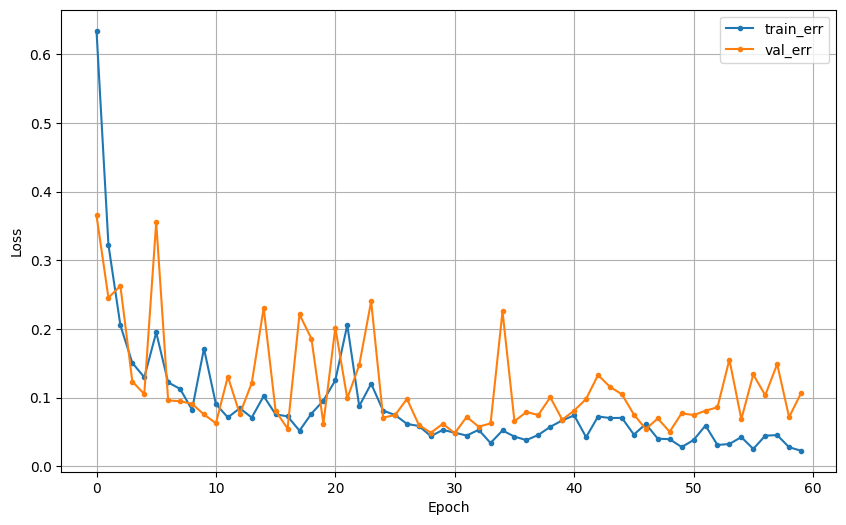

In [ ]:
dl_history_plot(hist)


In [ ]:
y_pred = model_dnn_static.predict(x_val)
y_pred_1 = y_pred.argmax(axis = 1)

print(confusion_matrix(y_val, y_pred_1))
print(classification_report(y_val, y_pred_1))

31/31 [==============================] - 0s 3ms/step
[[319   1   0]
 [  3 312   2]
 [  0  39 295]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       320
           1       0.89      0.98      0.93       317
           2       0.99      0.88      0.94       334

    accuracy                           0.95       971
   macro avg       0.96      0.95      0.95       971
weighted avg       0.96      0.95      0.95       971



In [ ]:
result_2['DNN'] = model_dnn_static.evaluate(x_val, y_val)
result_2

31/31 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.9537


{'Random_Forest': 0.945417095777549,
 'DNN': [0.19812360405921936, 0.953656017780304]}

In [ ]:
model_dnn_static.save('model_dnn_static.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
explainer = shap.DeepExplainer(model_dnn, x_train)

start_time = time.time()
shap_values = explainer.shap_values(x_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("SHAP 값을 계산하는데 걸린 시간: ", elapsed_time, "초")

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


SHAP 값을 계산하는데 걸린 시간:  596.8851642608643 초


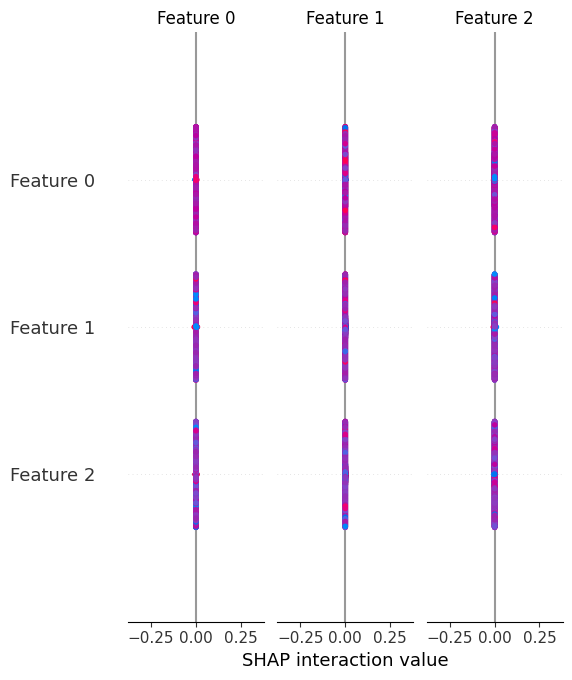

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type='bar')

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
is_dynamic_col = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data_is_dynamic = data.loc[data['Activity'].isin(is_dynamic_col)]

In [ ]:
label_change = {'WALKING' : 0,
                'WALKING_UPSTAIRS' : 1,
                'WALKING_DOWNSTAIRS' : 2}
data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)

<ipython-input-84-1d08a3c788a4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)


In [ ]:
target_y1 = 'Activity'
target_y2 = 'Activity_dynamic'

x = data_is_dynamic.drop([target_y1,target_y2], axis=1)
y1 = data_is_dynamic.loc[:,target_y1]
y2 = data_is_dynamic.loc[:,target_y2]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y1,
                                                  test_size=0.3,
                                                  random_state=1)

#### 1) 알고리즘1: RandomForestClassifier



In [ ]:
model_rf = RandomForestClassifier(max_depth=5,
                               random_state = 1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [ ]:
y_pred_rf = model_rf.predict(x_val)

In [ ]:
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

[[298   5   4]
 [  2 240   3]
 [  7   5 231]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       307
           1       0.96      0.98      0.97       245
           2       0.97      0.95      0.96       243

    accuracy                           0.97       795
   macro avg       0.97      0.97      0.97       795
weighted avg       0.97      0.97      0.97       795



In [ ]:
result_3 = {}
result_3['Random_Forest'] = model_rf.score(x_val, y_val)

,feature_name,feature_importance
0,"tGravityAcc-arCoeff()-Z,3",0.029383
1,tBodyAccMag-std(),0.028765
2,"tGravityAcc-arCoeff()-Z,1",0.027530
3,"tGravityAcc-arCoeff()-Z,4",0.026742
4,fBodyAccMag-mad(),0.025461
5,tGravityAccMag-std(),0.023128
6,"tGravityAcc-arCoeff()-Z,2",0.022692
7,"tGravityAcc-arCoeff()-Y,2",0.022563
8,fBodyAccMag-mean(),0.021796
9,tBodyAcc-energy()-X,0.021256


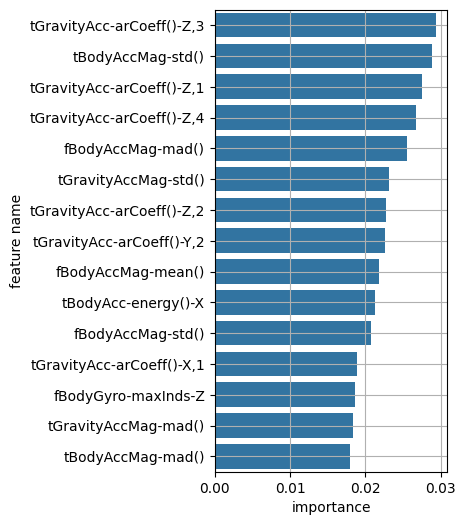

In [ ]:
# Feature importance 그리기
importance = model_rf.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

#### 2) 알고리즘2: DNN

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
# 모델설계
nfeatures = x_train.shape[1] # num of columns
nfeatures

561

In [ ]:
# 메모리 정리
clear_session()

# Sequential
model_dnn = Sequential([Dense(128, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(3 , activation = 'softmax')])

# 모델요약
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               71936     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 82851 (323.64 KB)
Trainable params: 82851 (323.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
lr = 0.01
epochs = 30

model_dnn.compile(optimizer=Adam(learning_rate=lr), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
validation_data=(x_val, y_val)
hist = model_dnn.fit(x_train, y_train, epochs = epochs, validation_split=0.2).history

Epoch 1/30
47/47 [==============================] - 1s 8ms/step - loss: 0.8027 - accuracy: 0.6570 - val_loss: 0.4938 - val_accuracy: 0.8167
Epoch 2/30
47/47 [==============================] - 0s 4ms/step - loss: 0.1959 - accuracy: 0.9372 - val_loss: 0.1473 - val_accuracy: 0.9623
Epoch 3/30
47/47 [==============================] - 0s 4ms/step - loss: 0.0908 - accuracy: 0.9642 - val_loss: 0.0676 - val_accuracy: 0.9704
Epoch 4/30
47/47 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.9872 - val_loss: 0.0441 - val_accuracy: 0.9784
Epoch 5/30
47/47 [==============================] - 0s 5ms/step - loss: 0.0565 - accuracy: 0.9784 - val_loss: 0.1774 - val_accuracy: 0.9434
Epoch 6/30
47/47 [==============================] - 0s 4ms/step - loss: 0.0485 - accuracy: 0.9824 - val_loss: 0.0519 - val_accuracy: 0.9838
Epoch 7/30
47/47 [==============================] - 0s 4ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.1115 - val_accuracy: 0.9757
Epoch 8/30
47/47 [==

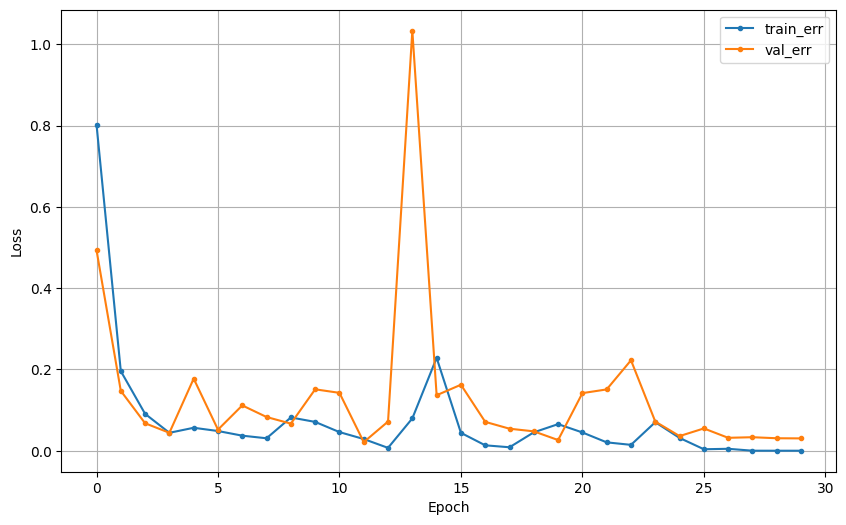

In [ ]:
dl_history_plot(hist)

In [ ]:
y_pred = model_dnn.predict(x_val)
y_pred_1 = y_pred.argmax(axis = 1)

print(confusion_matrix(y_val, y_pred_1))
print(classification_report(y_val, y_pred_1))

25/25 [==============================] - 0s 2ms/step
[[307   0   0]
 [  0 245   0]
 [  1   2 240]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       0.99      1.00      1.00       245
           2       1.00      0.99      0.99       243

    accuracy                           1.00       795
   macro avg       1.00      1.00      1.00       795
weighted avg       1.00      1.00      1.00       795



In [ ]:
result_3['DNN'] = model_dnn.evaluate(x_val, y_val)
result_3

25/25 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.9962


{'Random_Forest': 0.9672955974842767,
 'DNN': [0.010136852972209454, 0.99622642993927]}

### [선택사항] (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

In [27]:
def preprocess_data(data):
    label_change = {
        'STANDING': 0,
        'SITTING': 0,
        'LAYING': 0,
        'WALKING': 1,
        'WALKING_UPSTAIRS': 1,
        'WALKING_DOWNSTAIRS': 1
    }
    data['Activity_dynamic'] = data['Activity'].map(label_change)  # 정적 0, 동적 1

    # 특성과 레이블 분리
    target_y1 = 'Activity'
    target_y2 = 'Activity_dynamic'
    x = data.drop([target_y1, target_y2], axis=1)
    y1 = data.loc[:, target_y1]
    y2 = data.loc[:, target_y2]

    return x, y1, y2

def model1_rf(x_train, y_train, x_test, y_test, max_depth=5, random_state=1):
    # Random Forest 모델 생성 및 훈련
    model_rf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
    model_rf.fit(x_train, y_train)

    # 검증 데이터에 대한 예측
    y_pred_rf = model_rf.predict(x_test)

    # 성능 평가
    confusion_mat = confusion_matrix(y_test, y_pred_rf)
    classification_rep = classification_report(y_test, y_pred_rf)
    accuracy = model_rf.score(x_test, y_test)

    print('=' * 60)
    print('# 모델1(정적/동작 행동 분류) : test 성능지표')
    print(confusion_mat)
    print(classification_rep)
    print("정확도:", accuracy)

    return model_rf

def model1_svm(x_train, y_train, x_test, y_test, kernel='rbf', C=100.0):
    # Random Forest 모델 생성 및 훈련
    model_svm = SVC(kernel=kernel, C=C)
    model_svm.fit(x_train, y_train)

    # 검증 데이터에 대한 예측
    y_pred_svm = model_svm.predict(x_test)

    # 성능 평가
    confusion_mat = confusion_matrix(y_test, y_pred_svm)
    classification_rep = classification_report(y_test, y_pred_svm)
    accuracy = model_svm.score(x_test, y_test)

    print('=' * 60)
    print('# 모델1(정적/동작 행동 분류) : test 성능지표')
    print(confusion_mat)
    print(classification_rep)
    print("정확도:", accuracy)

    return model_svm

In [39]:
def preprocess_data2(data):
    is_static_col = ['LAYING', 'SITTING', 'STANDING']
    data_is_static = data.loc[data['Activity'].isin(is_static_col)]

    label_change = {'LAYING' : 0,
                    'SITTING' : 1,
                    'STANDING' : 2}
    data_is_static['Activity'] = data_is_static['Activity'].map(label_change)

    # 특성과 레이블 분리
    target_y1 = 'Activity'
    target_y2 = 'Activity_dynamic'
    x = data_is_static.drop([target_y1, target_y2], axis=1)
    y1 = data_is_static.loc[:, target_y1]
    y2 = data_is_static.loc[:, target_y2]

    return x, y1, y2


def model2_rf(x_train, y_train, x_test, y_test, max_depth=5, random_state=1):
    # Random Forest 모델 생성 및 훈련
    model_rf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
    model_rf.fit(x_train, y_train)

    # 검증 데이터에 대한 예측
    y_pred_rf = model_rf.predict(x_test)

    # 성능 평가
    confusion_mat = confusion_matrix(y_test, y_pred_rf)
    classification_rep = classification_report(y_test, y_pred_rf)
    accuracy = model_rf.score(x_test, y_test)

    print('=' * 60)
    print('# 모델2(정적 동작 세부 분류) : test 성능지표')
    print(confusion_mat)
    print(classification_rep)
    print("정확도:", accuracy)

    return model_rf

def model2_svm(x_train, y_train, x_test, y_test, kernel='rbf', C=100.0):
    # Random Forest 모델 생성 및 훈련
    model_svm = SVC(kernel=kernel, C=C, decision_function_shape='ovr')
    model_svm.fit(x_train, y_train)

    # 검증 데이터에 대한 예측
    y_pred_svm = model_svm.predict(x_test)

    # 성능 평가
    confusion_mat = confusion_matrix(y_test, y_pred_svm)
    classification_rep = classification_report(y_test, y_pred_svm)
    accuracy = model_svm.score(x_test, y_test)

    print('=' * 60)
    print('# 모델2(정적 동작 세부 분류) : test 성능지표')
    print(confusion_mat)
    print(classification_rep)
    print("정확도:", accuracy)

    return model_svm

In [44]:
def preprocess_data2_2(data):
    is_dynamic_col = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
    data_is_dynamic = data.loc[data['Activity'].isin(is_dynamic_col)]

    label_change = {'WALKING' : 0,
                'WALKING_UPSTAIRS' : 1,
                'WALKING_DOWNSTAIRS' : 2}
    data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)

    # 특성과 레이블 분리
    target_y1 = 'Activity'
    target_y2 = 'Activity_dynamic'
    x = data_is_dynamic.drop([target_y1, target_y2], axis=1)
    y1 = data_is_dynamic.loc[:, target_y1]
    y2 = data_is_dynamic.loc[:, target_y2]

    return x, y1, y2


def model2_2_rf(x_train, y_train, x_test, y_test, max_depth=5, random_state=1):
    # Random Forest 모델 생성 및 훈련
    model_rf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
    model_rf.fit(x_train, y_train)

    # 검증 데이터에 대한 예측
    y_pred_rf = model_rf.predict(x_test)

    # 성능 평가
    confusion_mat = confusion_matrix(y_test, y_pred_rf)
    classification_rep = classification_report(y_test, y_pred_rf)
    accuracy = model_rf.score(x_test, y_test)

    print('=' * 60)
    print('# 모델3(동적 동작 세부 분류) : test 성능지표')
    print(confusion_mat)
    print(classification_rep)
    print("정확도:", accuracy)

    return model_rf


def model2_2_svm(x_train, y_train, x_test, y_test, kernel='rbf', C=100.0):
    # Random Forest 모델 생성 및 훈련
    model_svm = SVC(kernel=kernel, C=C, decision_function_shape='ovr')
    model_svm.fit(x_train, y_train)

    # 검증 데이터에 대한 예측
    y_pred_svm = model_svm.predict(x_test)

    # 성능 평가
    confusion_mat = confusion_matrix(y_test, y_pred_svm)
    classification_rep = classification_report(y_test, y_pred_svm)
    accuracy = model_svm.score(x_test, y_test)

    print('=' * 60)
    print('# 모델3(동적 동작 세부 분류) : test 성능지표')
    print(confusion_mat)
    print(classification_rep)
    print("정확도:", accuracy)

    return model_svm

In [28]:
print("모델1 : Random Forest 결과")
x_train, y1_train, y2_train = preprocess_data(data)
x_test, y1_test, y2_test = preprocess_data(new_data)
model1_rf = model1_rf(x_train, y2_train, x_test, y2_test)

모델1 : Random Forest 결과
# 모델1(정적/동작 행동 분류) : test 성능지표
[[833   0]
 [  0 638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

정확도: 1.0


In [29]:
print("모델1 : SVM 결과")
x_train, y1_train, y2_train = preprocess_data(data)
x_test, y1_test, y2_test = preprocess_data(new_data)
model1_svm = model1_svm(x_train, y2_train, x_test, y2_test)

모델1 : SVM 결과
# 모델1(정적/동작 행동 분류) : test 성능지표
[[833   0]
 [  0 638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

정확도: 1.0


In [30]:
print("모델2 : Random Forest 결과")
x_train, y1_train, y2_train = preprocess_data2(data)
x_test, y1_test, y2_test = preprocess_data2(new_data)
model2_rf = model2_rf(x_train, y1_train, x_test, y1_test)

모델2 : Random Forest 결과


<ipython-input-22-3fcb2164dd00>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_static['Activity'] = data_is_static['Activity'].map(label_change)
<ipython-input-22-3fcb2164dd00>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_static['Activity'] = data_is_static['Activity'].map(label_change)


# 모델2(정적 동작 세부 분류) : test 성능지표
[[291   1   0]
 [  0 231  23]
 [  0  25 262]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.90      0.91      0.90       254
           2       0.92      0.91      0.92       287

    accuracy                           0.94       833
   macro avg       0.94      0.94      0.94       833
weighted avg       0.94      0.94      0.94       833

정확도: 0.9411764705882353


In [43]:
print("모델2 : SVM 결과")
x_train, y1_train, y2_train = preprocess_data2(data)
x_test, y1_test, y2_test = preprocess_data2(new_data)
model2_svm = model2_svm(x_train, y1_train, x_test, y1_test)

모델2 : SVM 결과


<ipython-input-39-6ea1b4f4bcf2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_static['Activity'] = data_is_static['Activity'].map(label_change)
<ipython-input-39-6ea1b4f4bcf2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_static['Activity'] = data_is_static['Activity'].map(label_change)


# 모델2(정적 동작 세부 분류) : test 성능지표
[[292   0   0]
 [  0 247   7]
 [  0   7 280]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.97      0.97      0.97       254
           2       0.98      0.98      0.98       287

    accuracy                           0.98       833
   macro avg       0.98      0.98      0.98       833
weighted avg       0.98      0.98      0.98       833

정확도: 0.9831932773109243


In [48]:
print("모델3 : Random forest 결과")
x_train, y1_train, y2_train = preprocess_data2_2(data)
x_test, y1_test, y2_test = preprocess_data2_2(new_data)
model2_2_rf = model2_2_rf(x_train, y1_train, x_test, y1_test)

모델3 : Random forest 결과


<ipython-input-44-e362690d1a8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)
<ipython-input-44-e362690d1a8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)


# 모델3(동적 동작 세부 분류) : test 성능지표
[[222   6   0]
 [  5 206   4]
 [  6   3 186]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       228
           1       0.96      0.96      0.96       215
           2       0.98      0.95      0.97       195

    accuracy                           0.96       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.96      0.96      0.96       638

정확도: 0.9623824451410659


In [49]:
print("모델3 : svm 결과")
x_train, y1_train, y2_train = preprocess_data2_2(data)
x_test, y1_test, y2_test = preprocess_data2_2(new_data)
model2_2_svm = model2_2_svm(x_train, y1_train, x_test, y1_test)

모델3 : svm 결과


<ipython-input-44-e362690d1a8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)
<ipython-input-44-e362690d1a8e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_is_dynamic['Activity'] = data_is_dynamic['Activity'].map(label_change)


# 모델3(동적 동작 세부 분류) : test 성능지표
[[228   0   0]
 [  1 214   0]
 [  0   0 195]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00       215
           2       1.00      1.00      1.00       195

    accuracy                           1.00       638
   macro avg       1.00      1.00      1.00       638
weighted avg       1.00      1.00      1.00       638

정확도: 0.9984326018808778
